<a href="https://colab.research.google.com/github/LenaVolzhina/playing-with-neural-networks/blob/master/DL_chapter_8_AAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np, tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


def batch_gen(data, batch_n):
  inds = range(data.shape[0])
  np.random.shuffle(inds)
  for i in range(data.shape[0] / batch_n):
    ii = inds[i*batch_n:(i+1)*batch_n]
    yield data[ii, :]

def he_initializer(size):
  return tf.random_normal_initializer(mean=0.0,
    stddev=np.sqrt(1./size), seed=None, dtype=tf.float32)
  
def linear_layer(tensor, input_size, out_size, init_fn=he_initializer,):
  W = tf.get_variable('W', shape=[input_size, out_size],
    initializer=init_fn(input_size))
  b = tf.get_variable('b', shape=[out_size],
    initializer=tf.constant_initializer(0.1))
  return tf.add(tf.matmul(tensor, W), b)

def sample_prior(loc=0., scale=1., size=(64, 10)):
  return np.tanh(np.random.normal(loc=loc, scale=scale, size=size))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [0]:
class AAE(object):
  def __init__(self, batch_size=64, input_space=28*28,
               latent_space=10, p=3., middle_layers=None,
               activation_fn=tf.nn.tanh, learning_rate=0.001, l2_lambda = 0.001,
               initializer_fn=he_initializer):
    self.batch_size = batch_size
    self.input_space = input_space
    self.latent_space = latent_space
    self.p = p
    self.middle_layers = [1024, 1024]
    self.activation_fn = activation_fn
    self.learning_rate = learning_rate
    self.initializer_fn = initializer_fn

    tf.reset_default_graph()
    self.input_x = tf.placeholder(tf.float32, [None, input_space])
    self.z_tensor = tf.placeholder(tf.float32, [None, latent_space])

    with tf.variable_scope("encoder"):
      self._encoder()
    self.encoded = self.encoder_layers[-1]
    
    with tf.variable_scope("decoder"):
      self.decoder_layers = self._decoder(self.encoded)
      self.decoded = self.decoder_layers[-1]
      tf.get_variable_scope().reuse_variables()
      self.generator_layers = self._decoder(self.z_tensor)
      self.generated = tf.nn.sigmoid(
        self.generator_layers[-1], name="generated")
    
    sizes = [64, 64, 1]
    with tf.variable_scope("discriminator"):
      self.disc_layers_neg = self._discriminator(self.encoded, sizes)
      self.disc_neg = self.disc_layers_neg[-1]
      tf.get_variable_scope().reuse_variables()
      self.disc_layers_pos = self._discriminator(self.z_tensor, sizes)
      self.disc_pos = self.disc_layers_pos[-1]

    self.pos_loss = (
      tf.nn.relu(self.disc_pos) - self.disc_pos
      + tf.log(1.0 + tf.exp(-tf.abs(self.disc_pos)))
    )
    self.neg_loss = (
      tf.nn.relu(self.disc_neg)
      + tf.log(1.0 + tf.exp(-tf.abs(self.disc_neg)))
    )
    self.disc_loss = tf.reduce_mean(tf.add(self.pos_loss, self.neg_loss))
    self.enc_loss = tf.reduce_mean(tf.subtract(self.neg_loss, self.disc_neg))
    batch_logloss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(
      logits=self.decoded, labels=self.input_x), 1)
    self.ae_loss = tf.reduce_mean(batch_logloss)
    disc_ws = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='discriminator')
    ae_ws = (
      tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='encoder') +
      tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='decoder')
    )
    self.l2_loss = tf.multiply(tf.reduce_sum([tf.nn.l2_loss(ws) for ws in ae_ws]),
      l2_lambda)
    
    self.gen_loss = tf.add(tf.add(self.enc_loss, self.ae_loss), self.l2_loss)
    with tf.variable_scope('optimizers'):
      self.train_discriminator = (
        tf.train.RMSPropOptimizer(self.learning_rate)
        .minimize(self.disc_loss, var_list=disc_ws)
      )
      self.train_generator = (
        tf.train.RMSPropOptimizer(self.learning_rate)
        .minimize(self.gen_loss, var_list=ae_ws)
      )
    
    self.sess = tf.Session()
    init = tf.global_variables_initializer()
    self.sess.run(init)

  def _encoder(self):
    sizes = [self.input_space] + self.middle_layers + [self.latent_space]
    self.encoder_layers = [self.input_x]
    for i in range(len(sizes) - 1):
      with tf.variable_scope('layer-%s' % i):
        linear = linear_layer(self.encoder_layers[-1], sizes[i], sizes[i+1])
        self.encoder_layers.append(self.activation_fn(linear))
  
  def _decoder(self, tensor):
    sizes = [self.latent_space] + self.middle_layers[::-1]
    decoder_layers = [tensor]
    for i in range(len(sizes) - 1):
      with tf.variable_scope('layer-%s' % i):
        linear = linear_layer(decoder_layers[-1], sizes[i], sizes[i+1])
        decoder_layers.append(self.activation_fn(linear))
    with tf.variable_scope('output-layer'):
      linear = linear_layer(decoder_layers[-1], sizes[-1], self.input_space)
      decoder_layers.append(linear)
    return decoder_layers
  
  def _discriminator(self, tensor, sizes):
    sizes = [self.latent_space] + sizes + [1]
    disc_layers = [tensor]
    for i in range(len(sizes) - 1):
      with tf.variable_scope('layer-%s' % i):
        linear = linear_layer(disc_layers[-1], sizes[i], sizes[i+1])
        disc_layers.append(self.activation_fn(linear))
    with tf.variable_scope('class-layer'):
      linear = linear_layer(disc_layers[-1], sizes[-1], self.input_space)
      disc_layers.append(linear)
    return disc_layers

  def train(self, nepochs=1000, step=100):
    sess = self.sess
    test_x = mnist.test.images
    gloss = 0.69
    
    for i in range(nepochs):
      batch_x, _ = mnist.train.next_batch(self.batch_size)
      if gloss > np.log(self.p):
        gloss, _ = sess.run([self.enc_loss, self.train_generator],
          feed_dict={self.input_x: batch_x})
      else:
        batch_z = sample_prior(
          scale=1.0, size=(len(batch_x), self.latent_space))
        gloss, _ = sess.run([self.enc_loss, self.train_discriminator],
          feed_dict={self.input_x: batch_x, self.z_tensor: batch_z})
      
      if i % step == 0:
        gtd = aae.sess.run(aae.generated,
          feed_dict={aae.z_tensor: sample_prior(size=(4, 10))})
        plot_mnist(gtd.reshape([4, 28, 28]), epoch=i)

Обратите внимание, что то, какой из
двух оптимизаторов запускать, определяется текущими значениями ошибок: пока
ошибка кодировщика больше заданного значения, мы дообучаем генератор, а когда
становится меньше, возвращаемся к дискриминатору.

In [0]:
import matplotlib.pyplot as plt

def plot_mnist(pictures, epoch):
  n = len(pictures)
  #plt.figure()
  _, axes = plt.subplots(ncols=n)
  for img, ax in zip(pictures, axes):
    ax.imshow(img)
  plt.title(f'Epoch={epoch}')

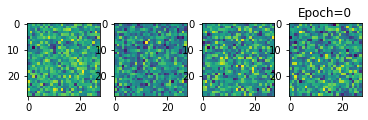

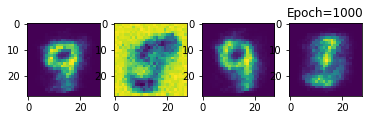

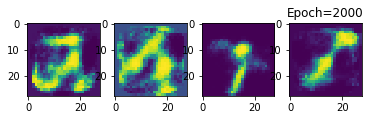

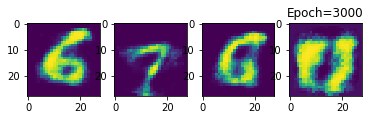

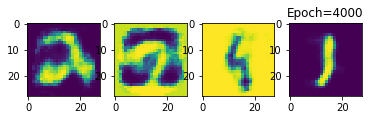

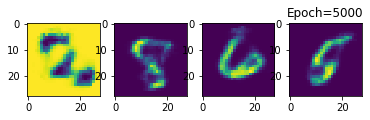

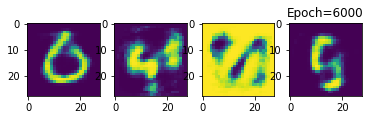

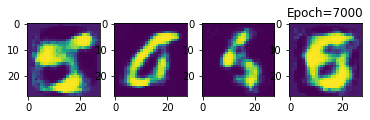

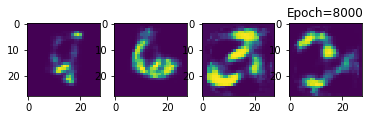

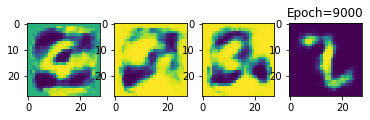

In [21]:
aae = AAE()
aae.train(nepochs=10000, step=1000)